In [4]:
import Models.Segnet
import Models.Unet
import Models.PspNet
import Models.DeepLab

import sys
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix


In [2]:
gtPath = "_conv3/"
rgbPath = "_out/"

gtFileNames = os.listdir(gtPath)
outFileNames = os.listdir(rgbPath)

matchingFiles = set(outFileNames) & set(gtFileNames)

In [3]:
NumTrainingImages = 10000
StartingIndex = 0

random.seed(2)
FileNames = random.sample(matchingFiles, NumTrainingImages)

                            
gtFileNames = gtFileNames[StartingIndex:StartingIndex+NumTrainingImages]
outFileNames = outFileNames [StartingIndex:StartingIndex+NumTrainingImages]

for i in range(0,NumTrainingImages):
    gtFileNames[i] = gtPath + FileNames[i]
    outFileNames[i] = rgbPath + FileNames[i]
    

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(outFileNames, gtFileNames, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
def loadImage(outPath, gtPath):
    
    img = tf.io.read_file(outPath)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = img[:1000, 460:1460, :] # Crop the photo (bonnet &)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(gtPath)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = mask[:1000, 460:1460, :] # Crop the bonnet
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [6]:
def genDataset(outPath, gtPath, bufferSize, batchSize):
    
    imageList = tf.constant(outPath) 
    maskList = tf.constant(gtPath)
    dataset = tf.data.Dataset.from_tensor_slices((imageList, maskList))
    dataset = dataset.map(loadImage, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache().shuffle(bufferSize).batch(batchSize)
    
    return dataset



In [7]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask[0]


In [8]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [9]:
def show_predictions(model, dataset, num):
    predictions = []
    masks = []
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
        predictions.append(create_mask(pred_mask))
        masks.append(mask[0])
    return predictions,masks


In [10]:
def predictDataset(dataset,model):
    preds = []
    masks = []
    for image, mask in dataset.take(len(dataset)):
        pred_mask = model.predict(image,verbose=0)
        masks.append(np.squeeze(mask[0]))
        preds.append(np.squeeze(create_mask(pred_mask)))
    flat_preds = np.concatenate(preds).flatten()
    flat_masks = np.concatenate(masks).flatten()
    return flat_preds,flat_masks


In [11]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, jaccard_score

def calculate_iou(y_true, y_pred): #Intersection over union
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_metrics(true_masks, predicted_masks):
    accuracy = accuracy_score(true_masks.flatten(), predicted_masks.flatten())
    precision = precision_score(true_masks.flatten(), predicted_masks.flatten())
    f1 = f1_score(true_masks.flatten(), predicted_masks.flatten())
    jaccard = jaccard_score(true_masks.flatten(), predicted_masks.flatten())
    iou = calculate_iou(true_masks.flatten(), predicted_masks.flatten())
    return accuracy, precision, f1, jaccard, iou


-------------------------------------------------------
------------------- Testing: Unet -----------------------
-------------------------------------------------------
Accuracy: 0.9981897747705853
Precision: 0.9836982467072368
F1 Score: 0.9812672314401725
Jaccard Index (IoU): 0.9632233905927854
Intersection over Union (IoU): 0.9632233905927854
[[ 195753    4230]
 [   3244 3925541]]
1/1 [==============================] - 0s 28ms/step


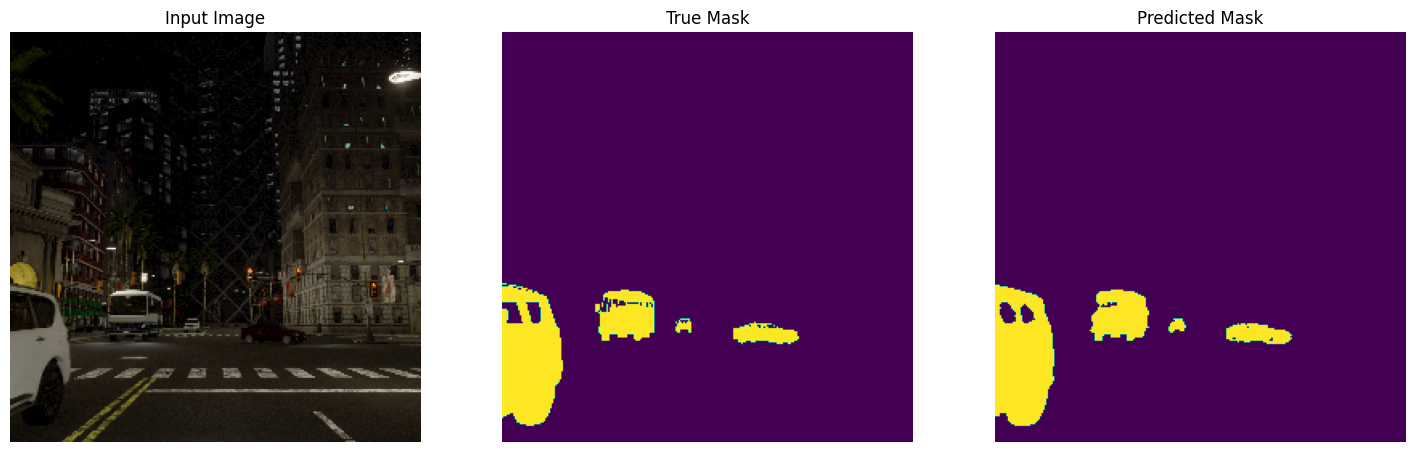

1/1 [==============================] - 0s 23ms/step


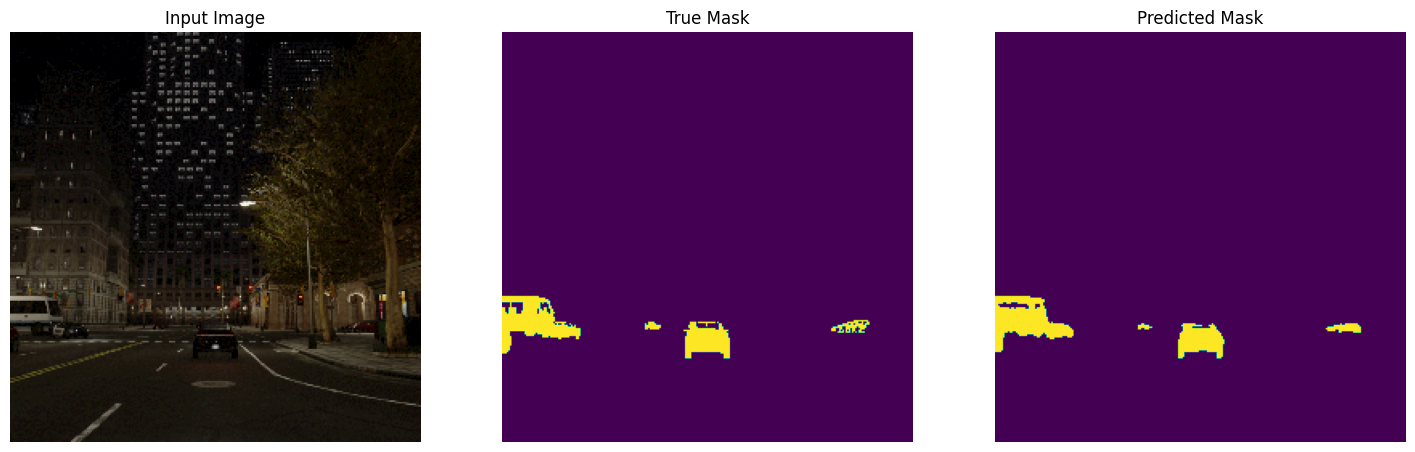

1/1 [==============================] - 0s 22ms/step


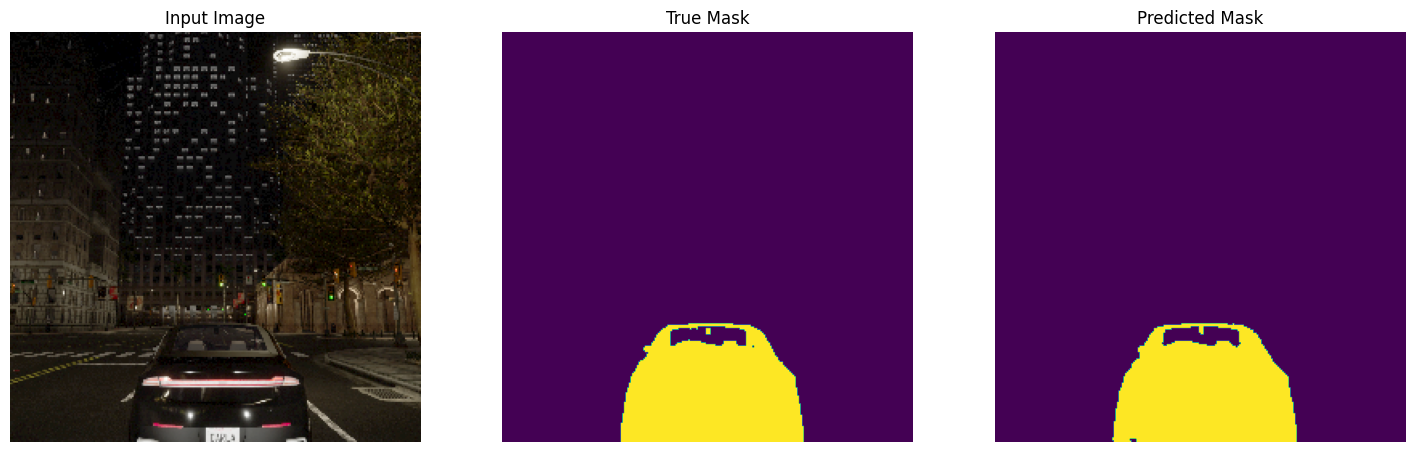

1/1 [==============================] - 0s 21ms/step


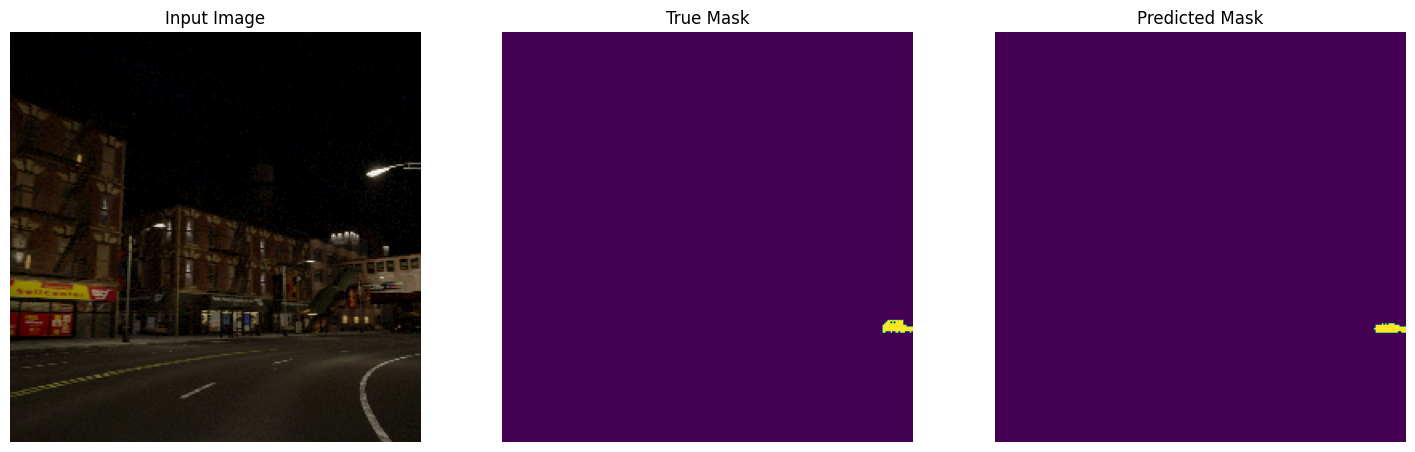

-------------------------------------------------------
------------------- Testing: DeepLab -----------------------
-------------------------------------------------------
Accuracy: 0.9931480771019345
Precision: 0.9608131501972638
F1 Score: 0.926017939799681
Jaccard Index (IoU): 0.8622284990747053
Intersection over Union (IoU): 0.8622284990747053
[[ 177050   21069]
 [   7221 3923428]]
1/1 [==============================] - 0s 30ms/step


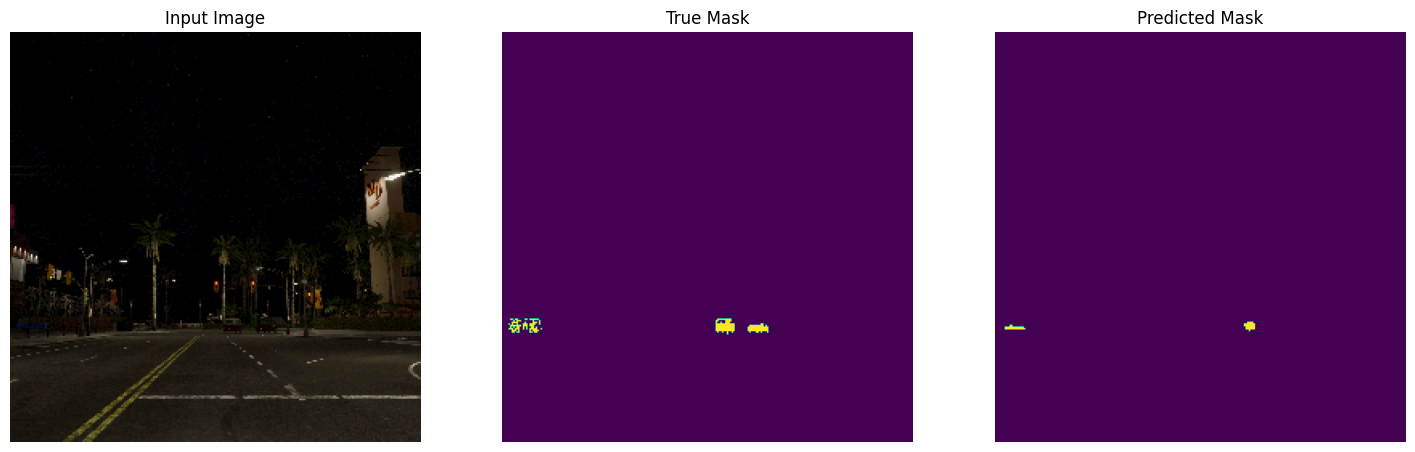

1/1 [==============================] - 0s 24ms/step


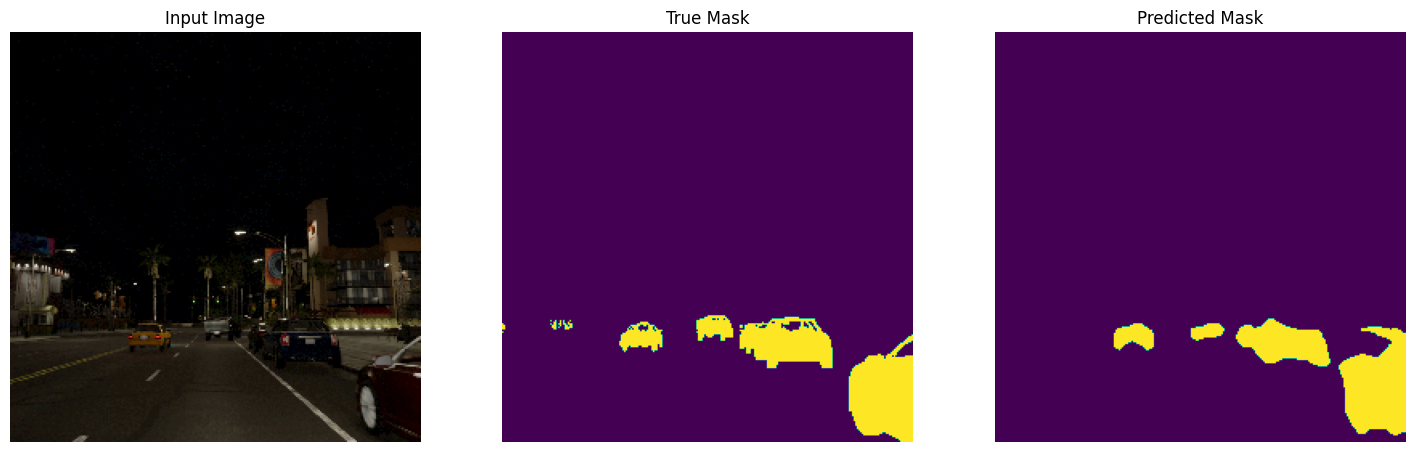

1/1 [==============================] - 0s 23ms/step


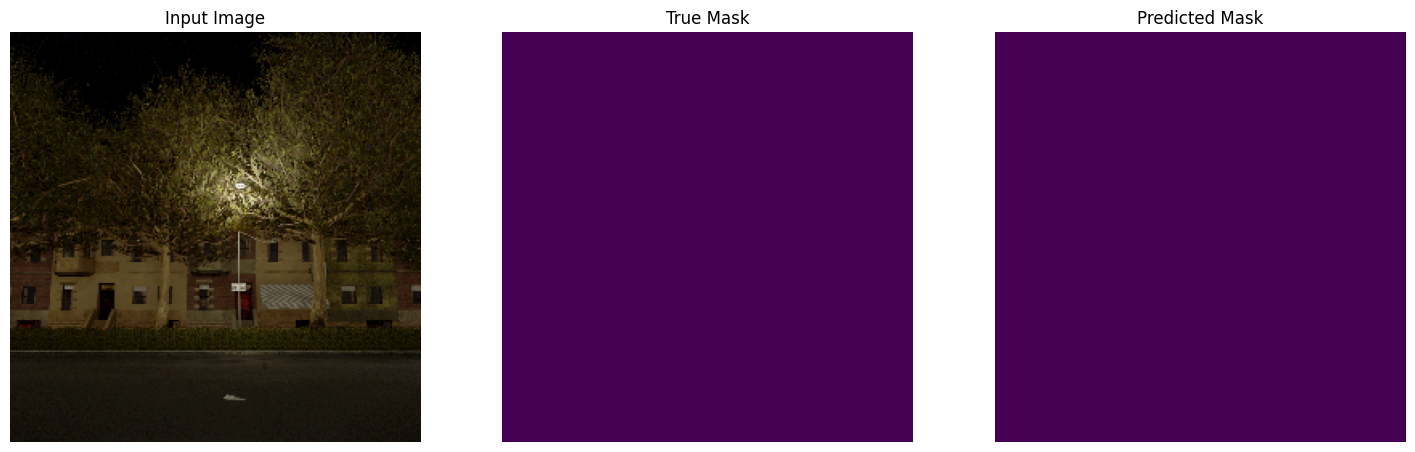

1/1 [==============================] - 0s 32ms/step


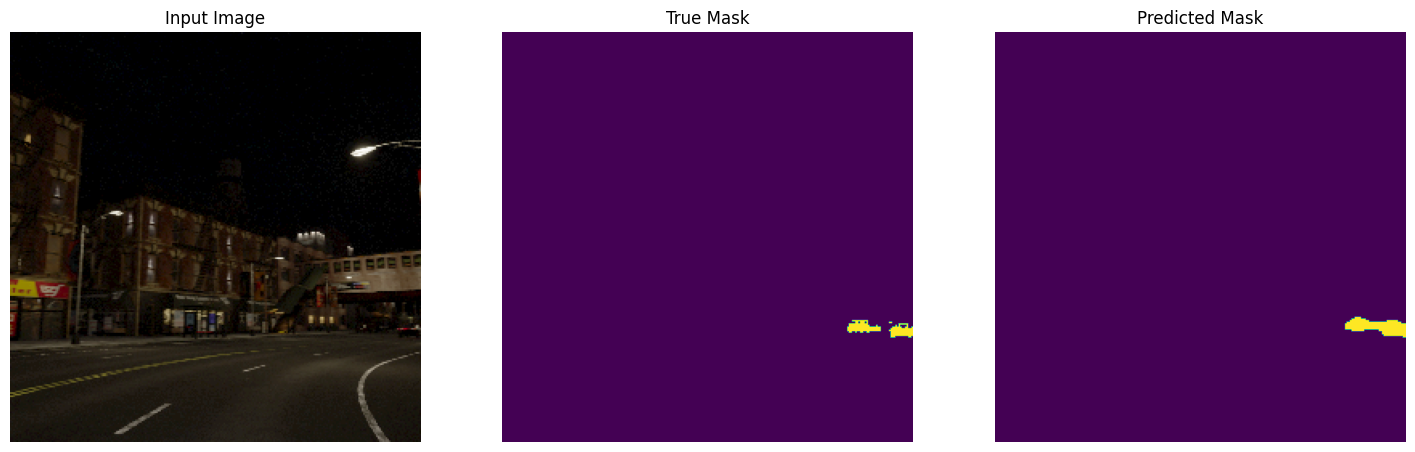

-------------------------------------------------------
------------------- Testing: Segnet -----------------------
-------------------------------------------------------
Accuracy: 0.9840475463867188
Precision: 0.9532451603011548
F1 Score: 0.7721976846293468
Jaccard Index (IoU): 0.6289267213152575
Intersection over Union (IoU): 0.6289267213152575
[[  354387   191710]
 [   17382 12543721]]
1/1 [==============================] - 0s 373ms/step


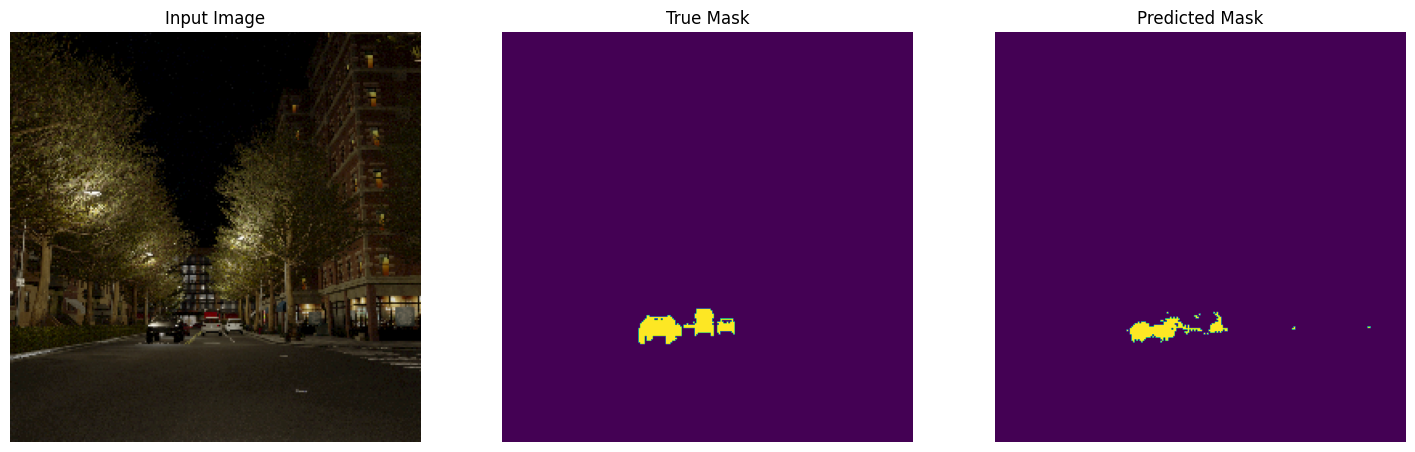

1/1 [==============================] - 0s 124ms/step


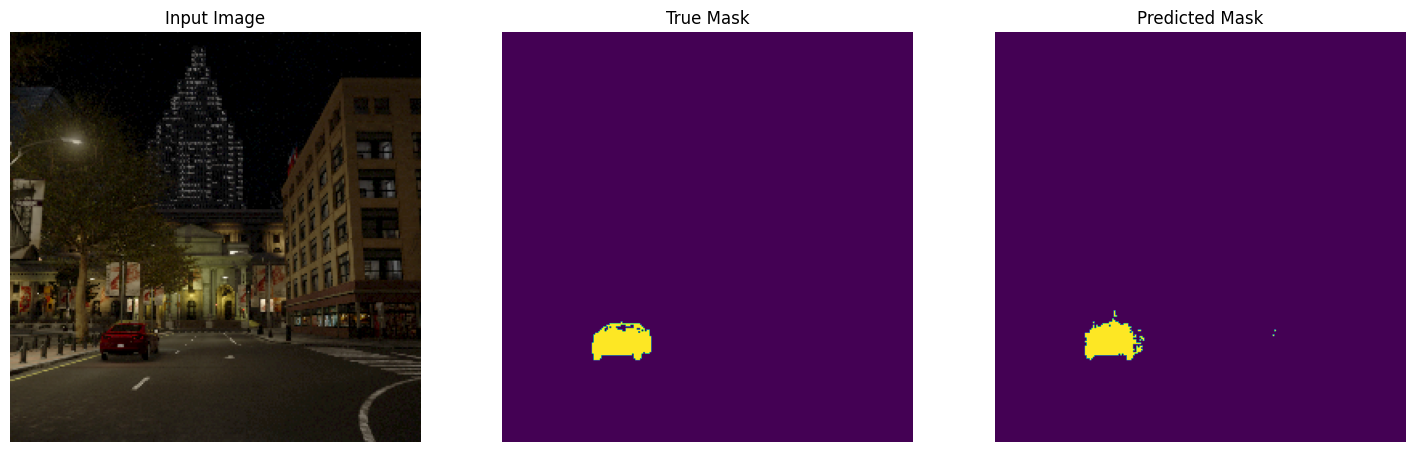

1/1 [==============================] - 0s 106ms/step


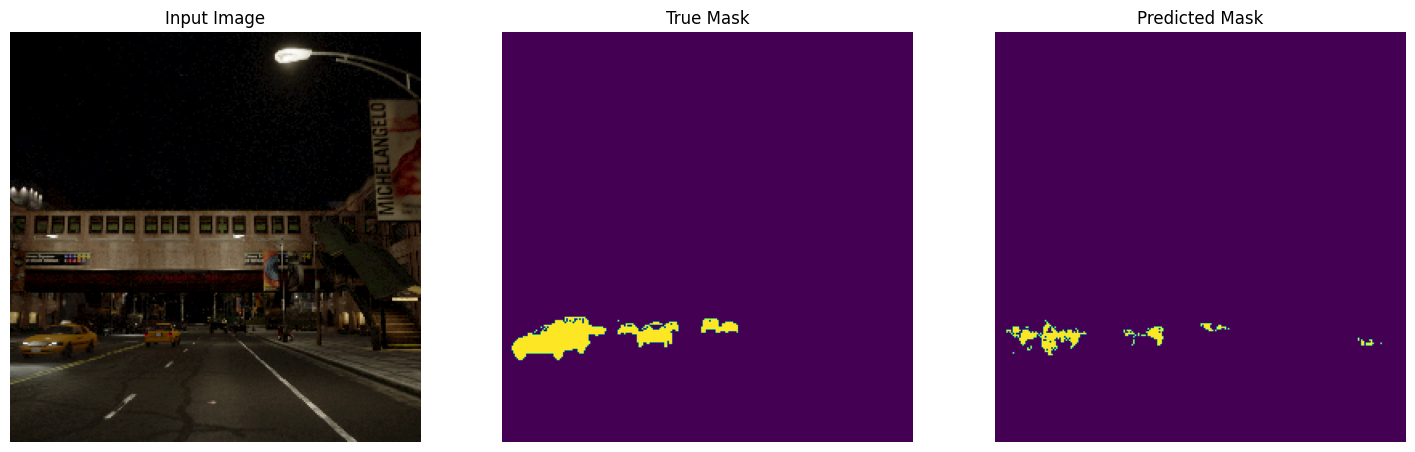

1/1 [==============================] - 0s 107ms/step


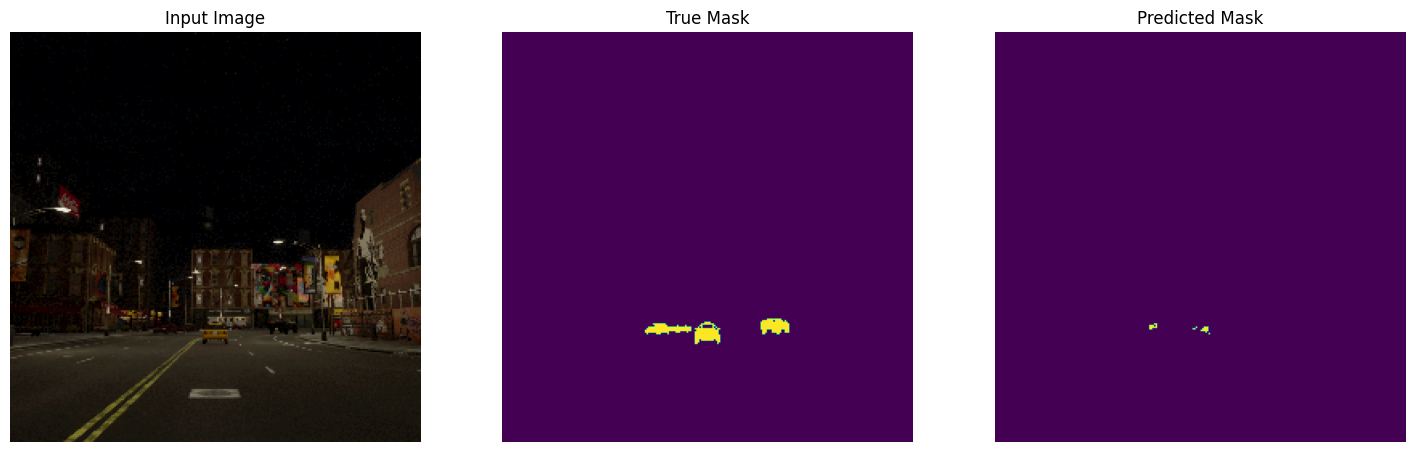

-------------------------------------------------------
------------------- Testing: PspNet -----------------------
-------------------------------------------------------
Accuracy: 0.9968659973144531
Precision: 0.9740061800567897
F1 Score: 0.9365630902135926
Jaccard Index (IoU): 0.8806945495259353
Intersection over Union (IoU): 0.8806945495259353
[[  606463    65971]
 [   16185 25525781]]
1/1 [==============================] - 0s 17ms/step


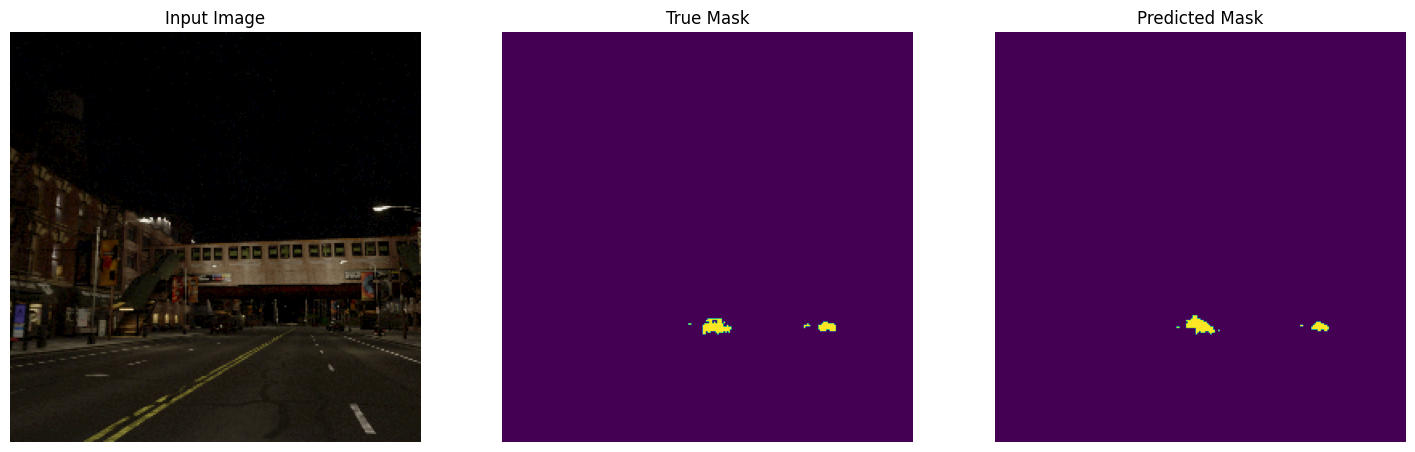

1/1 [==============================] - 0s 17ms/step


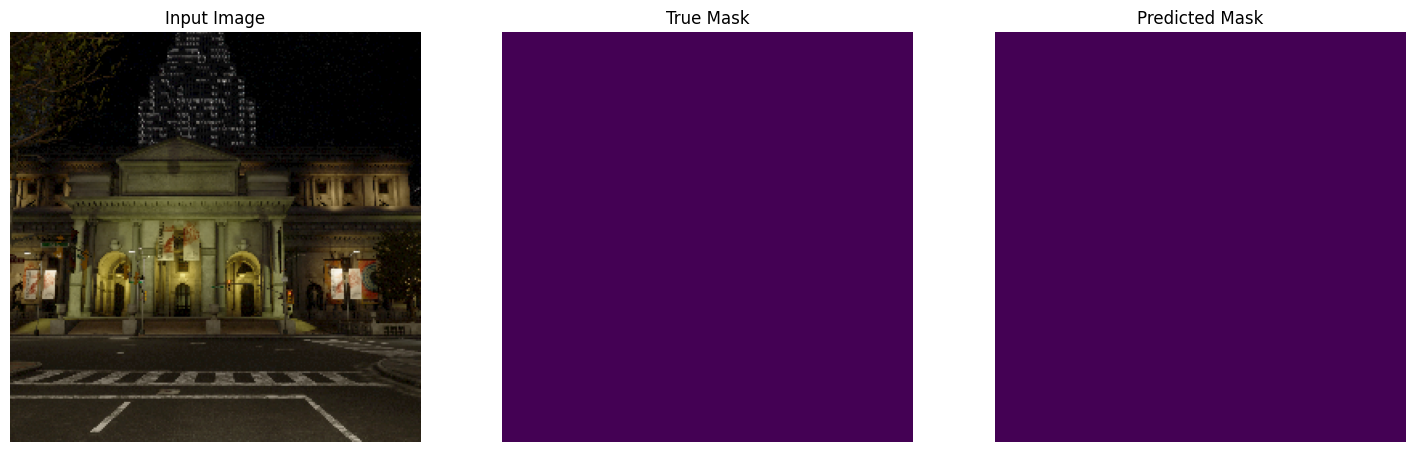

1/1 [==============================] - 0s 16ms/step


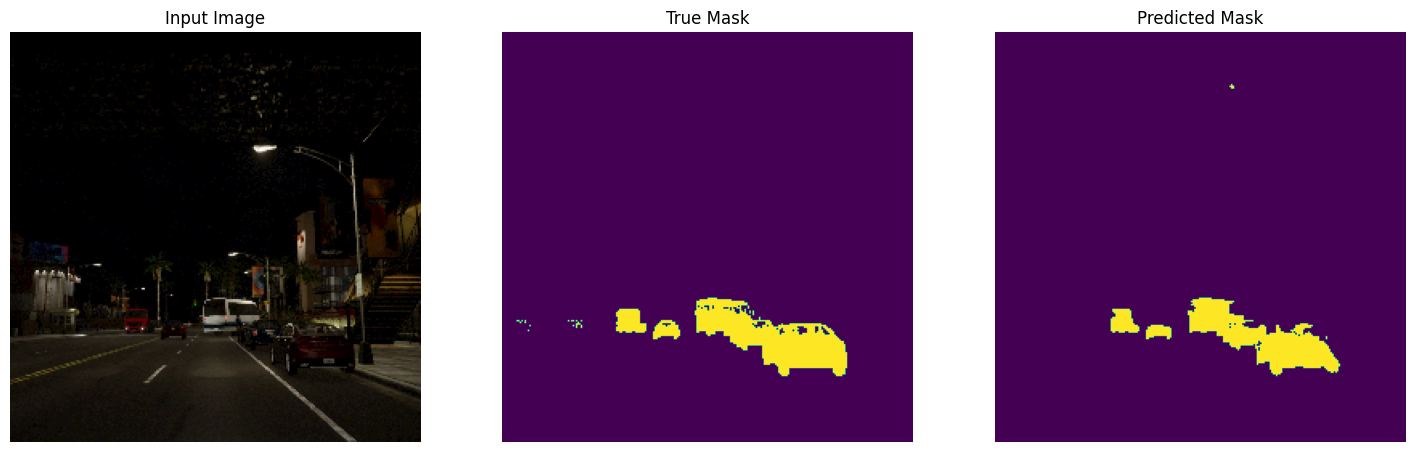

1/1 [==============================] - 0s 15ms/step


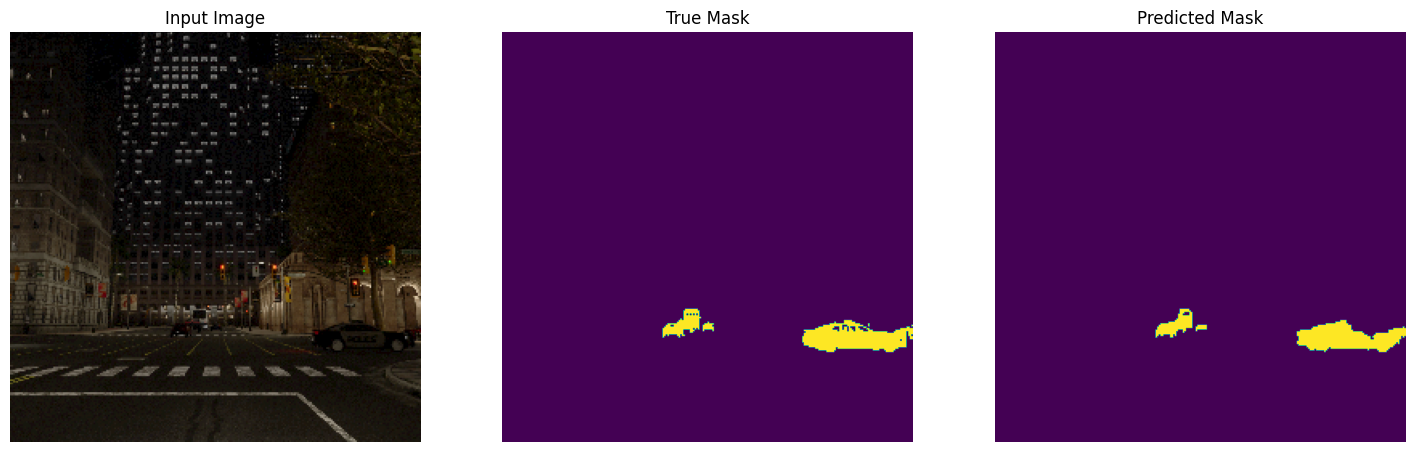

In [12]:
modelList = ['Unet','DeepLab','Segnet','PspNet']
model_metrics = {}

#modelChoice = 'Unet'
for modelChoice in modelList:

    print("-------------------------------------------------------")
    print("------------------- Testing: "+modelChoice+" -----------------------")
    print("-------------------------------------------------------")
    
    if(modelChoice == 'Segnet'):
        batchSize = 10 #Lower batchSize to fit into GPU mem
        bufferSize = 500
    elif(modelChoice == 'PspNet'):
        batchSize = 5 #Lower batchSize to fit into GPU mem
        bufferSize = 500
    else:
        batchSize = 32
        bufferSize = 500

    trainDataset = genDataset(X_train, y_train, bufferSize, batchSize)
    valDataset = genDataset(X_val, y_val, bufferSize, batchSize)
    testDataset = genDataset(X_test, y_test, bufferSize, batchSize)

    #Model Load

    if(modelChoice == 'Segnet'):
        custom_objects = {
            'MaxPoolingWithArgmax2D': Segnet.MaxPoolingWithArgmax2D,
            'MaxUnpooling2D':  Segnet.MaxUnpooling2D
        }
        
        model = tf.keras.models.load_model('/Models/'+modelChoice + '.h5', custom_objects=custom_objects)
    else:

        model = tf.keras.models.load_model('/Models/'+modelChoice + '.h5')
    

    flat_preds, flat_masks = predictDataset(testDataset, model)

    # Calculate evaluation metrics
    accuracy, precision, f1, jaccard, iou = calculate_metrics(flat_masks, flat_preds)
    confusion_m = confusion_matrix(flat_masks, flat_preds,labels=[1, 0])
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')
    print(f'Jaccard Index (IoU): {jaccard}')
    print(f'Intersection over Union (IoU): {iou}')
    print(confusion_m)

    model_metrics[modelChoice] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Jaccard Index (IoU)': jaccard,
        'Intersection over Union (IoU)': iou,
        'Confusion Matrix': confusion_m.tolist()  # Convert to list for better readability
    }

    show_predictions(model, testDataset,4)

In [13]:
import pandas as pd
# Create a DataFrame from the collected metrics dictionary
df = pd.DataFrame(model_metrics)

# Transpose the DataFrame for better readability
df = df.transpose()

# Display the DataFrame
print(df)

         Accuracy Precision  F1 Score Jaccard Index (IoU)  \
Unet      0.99819  0.983698  0.981267            0.963223   
DeepLab  0.993148  0.960813  0.926018            0.862228   
Segnet   0.984048  0.953245  0.772198            0.628927   
PspNet   0.996866  0.974006  0.936563            0.880695   

        Intersection over Union (IoU)                       Confusion Matrix  
Unet                         0.963223      [[195753, 4230], [3244, 3925541]]  
DeepLab                      0.862228     [[177050, 21069], [7221, 3923428]]  
Segnet                       0.628927  [[354387, 191710], [17382, 12543721]]  
PspNet                       0.880695   [[606463, 65971], [16185, 25525781]]  


In [14]:
rgbPath = "../NighttimeDrivingTest/leftImg8bit/test/night/"
gtPath =  "../NighttimeDrivingTest/gtCoarse_daytime_trainvaltest/test/night/"

modelList = ['Unet','DeepLab','Segnet','PspNet']

modelChoice = 'Segnet'

gtFileNames = os.listdir(gtPath)
outFileNames = os.listdir(rgbPath)

matchingFiles = set(outFileNames) & set(gtFileNames)

In [15]:

colorFileNames = []

for fileName in gtFileNames:
    if fileName.split('_')[4] == 'color.png':
        colorFileNames.append(fileName)


In [16]:
len(colorFileNames)

50

In [17]:
len(outFileNames)

50

In [18]:

for i in range(0,len(colorFileNames)):
    colorFileNames[i] = gtPath + colorFileNames[i]
    outFileNames[i] = rgbPath + outFileNames[i]

2/2 [==============================] - 8s 3s/step


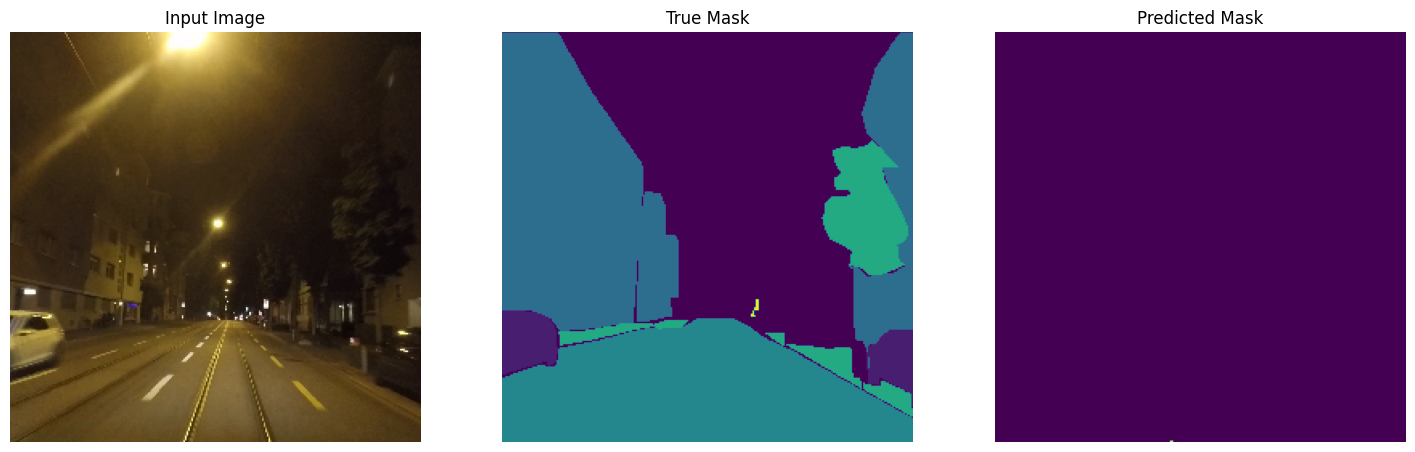

In [19]:
realDataset = genDataset(outFileNames, colorFileNames, 100, 100)
preds,masks = show_predictions(model, realDataset,50)
